<a href="https://colab.research.google.com/github/ppunkz/gold-price-forecasting/blob/master/ARIMA_Forecasting_gold_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Historical gold prices')

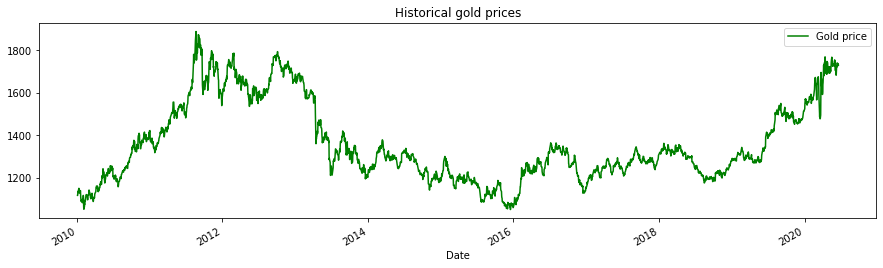

In [ ]:
#API Import data
#from pandas_datareader import data as pdr
#df = pdr.get_data_yahoo('GC=F', start = '2010-01-01', end = '2020-06-19')
#df = df[['Close']]
#Visualise data
#import matplotlib.pyplot as plt
#df['Close'].plot(color = 'green', figsize = (15,4))
#plt.legend(['Gold price'])
#plt.title('Historical gold prices')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving goldprice.csv to goldprice.csv


In [4]:
#import data set, set index as date
Col = ['Price','Date']
df = pd.read_csv('goldprice.csv', usecols=Col, parse_dates=['Date'],index_col=['Date'])
df = df.sort_values('Date')
df = df.dropna()

In [5]:
#split train and test data set with False shuffle because data is time series
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=.9, shuffle=False)

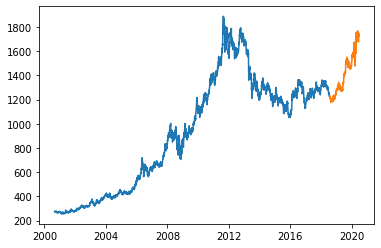

In [6]:
plt.plot(train['Price'])
plt.plot(test['Price'])
plt.show()

In [7]:
#to check if the time series stationary
#if p-value is less than 0.5, then it is stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train['Price'].dropna(), autolag = 'AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.310354
p-value: 0.624422


In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
#differencing 1st order
train['Diff'] = train['Price'].diff(1)
result = adfuller(train.loc[:,('Diff')].dropna(), autolag = 'AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


ADF Statistic: -20.849084
p-value: 0.000000


In [9]:
#differencing 2st order
train['DiffDiff'] = train['Diff'].diff(1)
result = adfuller(train.loc[:,('DiffDiff')].dropna(), autolag = 'AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ADF Statistic: -19.217684
p-value: 0.000000


Text(0.5, 1.0, 'Gold price values (diff)')

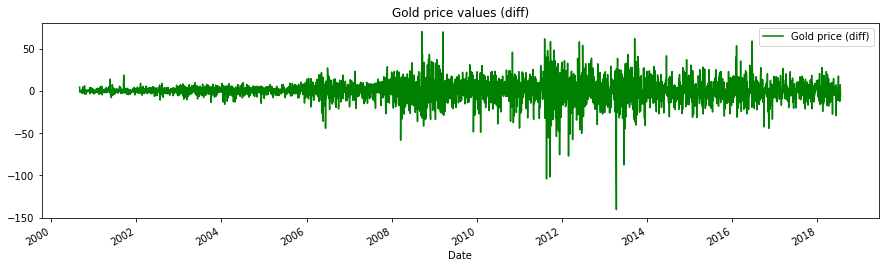

In [10]:
train['Diff'].plot(color = 'green', figsize = (15,4))
plt.legend(['Gold price (diff)'])
plt.title('Gold price values (diff)')

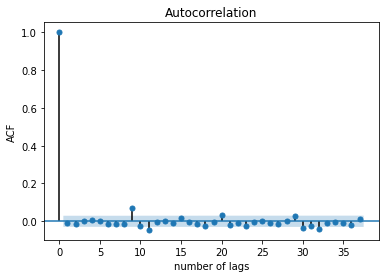

In [11]:
plot_acf(train['Diff'].dropna())
#plot_acf(train['DiffDiff'].dropna())
plt.xlabel('number of lags')
plt.ylabel('ACF')
plt.show()

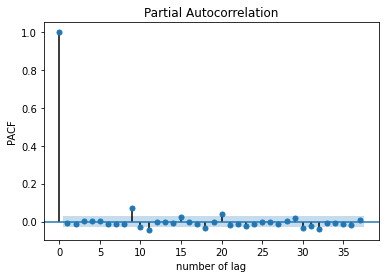

In [12]:
plot_pacf(train['Diff'].dropna())
plt.xlabel('number of lag')
plt.ylabel('PACF')
plt.show()

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train['Price'], order=(0,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 4460
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -17320.018
Method:                           css   S.D. of innovations             11.757
Date:                Sat, 15 Aug 2020   AIC                          34644.037
Time:                        14:51:56   BIC                          34656.843
Sample:                             1   HQIC                         34648.551
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2130      0.176      1.210      0.226      -0.132       0.558


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 720x360 with 0 Axes>

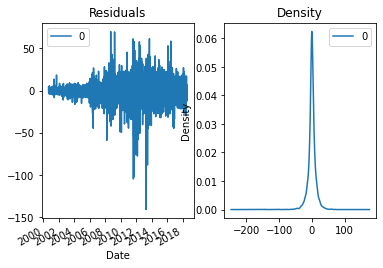

In [14]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

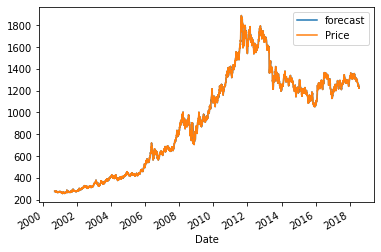

In [15]:
# Actual vs Fitted
#plt.figure(figsize=(20,5))
model_fit.plot_predict(dynamic=False)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 4460
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -17320.018
Method:                           css   S.D. of innovations             11.757
Date:                Sat, 15 Aug 2020   AIC                          34644.037
Time:                        14:52:11   BIC                          34656.843
Sample:                             1   HQIC                         34648.551
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2130      0.176      1.210      0.226      -0.132       0.558


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


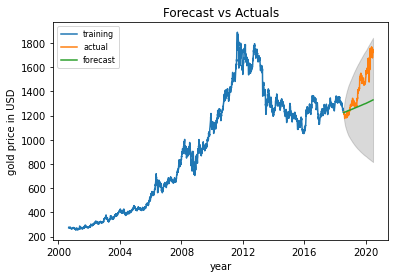

In [16]:
# Build Model
model = ARIMA(train['Price'], order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.plot(train['Price'], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('year')
plt.ylabel('gold price in USD')
plt.show()

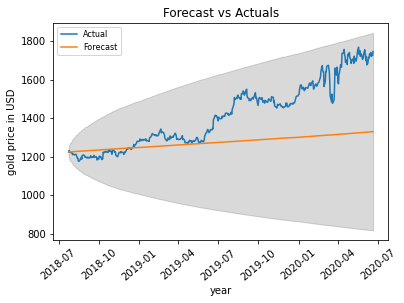

In [17]:
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('year')
plt.ylabel('gold price in USD')
plt.xticks(rotation=40)
plt.show()

In [18]:
RMSE = sqrt(mean_squared_error(fc, test['Price'].values))
MAE = mean_absolute_error(fc, test['Price'].values)
print('RMSE :' ,round(RMSE,2))
print('MAE :', round(MAE,2))

RMSE : 205.05
MAE : 156.14


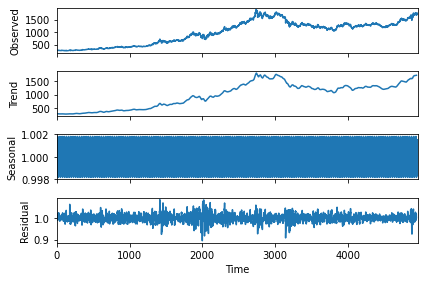

In [19]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
Col = ['Price','Date']
series = pd.read_csv('goldprice.csv', usecols=Col, index_col=0, header=0)
series = series.dropna()
result = seasonal_decompose(series.values, model='multiplicative', freq = 30)
result.plot()
pyplot.show()


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Price'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=34647.285, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34644.037, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34645.681, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34645.671, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34643.501, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.353 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4461
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -17320.750
Date:                Thu, 06 Aug 2020   AIC                          34643.501
Time:                        12:47:33   BIC                          34649.904
Sample:                             0   HQIC                         34645.758
                               - 4461                                  

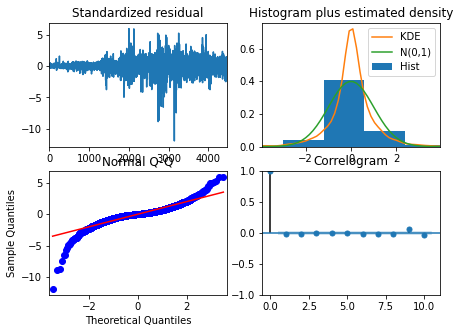

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

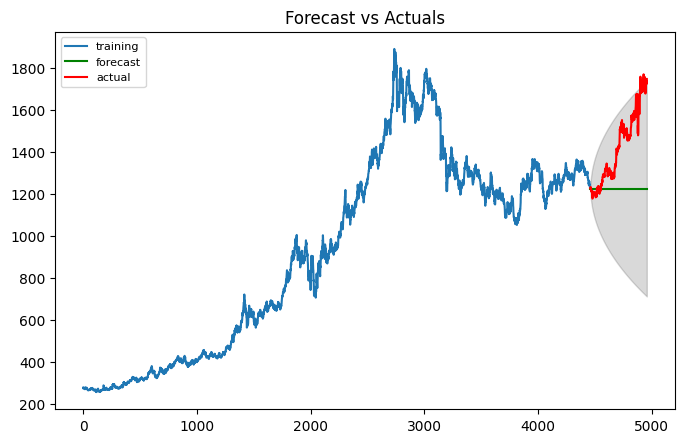

In [ ]:
# Forecast
n_periods = 496
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(train.values), len(train.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
test_series = pd.Series(test['Price'].values, index=index_of_fc)

# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(train['Price'].values, label='training')
plt.plot(fc_series, color='green', label='forecast')
plt.plot(test_series, color='red', label='actual')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
RMSE = sqrt(mean_squared_error(fc, test['Price'].values))
MAE = mean_absolute_error(fc, test['Price'].values)
print('RMSE :' ,round(RMSE,2))
print('MAE :', round(MAE,2))

RMSE : 263.82
MAE : 205.61
